In [117]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# Import statements required for Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

In [118]:
import os
data_folder = '/home/shuvayan/Downloads/Deloitte/'
attrition = pd.read_csv(data_folder + 'Attrition.csv')
attrition.head()

,Rehire,Terminated,Employee_code,Department,Job Level,Tenure,TimeLastPos,Has been promoted,LastRating,Client work travel,Education,Gender,Marital Status,Annual Income,Year of Birth,Age
0,False,1,140384,Risk Management,Senior Analyst,253,253,No,1.965571,High Travel,Bachelors Degree,F,Single,1678,1963,54
1,False,1,120921,Tax,Senior Analyst,1384,118,Yes,1.000000,Medium Travel,Bachelors Degree,M,Married,2144,1966,51
2,False,1,88512,Audit,Staff I,1188,482,Yes,2.000000,Medium Travel,Msc Analytics,M,Married,584,1977,40
3,False,1,80636,Financial Advisory,Lead Analyst,1013,1013,No,2.000000,Medium Travel,MA,F,Married,6205,1970,47
4,False,0,123543,Sales,Lead Analyst,1300,1132,Yes,2.000000,Medium Travel,MA,F,Married,6986,1970,47


In [119]:
#Drop the employee code:
attrition.drop('Employee_code', axis=1, inplace=True)
#Calculate age from DOB column : Assumption - Employees have left in 2017
attrition.drop('Year of Birth',axis = 1,inplace = True)
attrition.isnull().any()

Rehire                False
Terminated            False
Department             True
Job Level             False
Tenure                False
TimeLastPos           False
Has been promoted     False
LastRating            False
Client work travel    False
Education             False
Gender                False
Marital Status        False
Annual Income         False
Age                   False
dtype: bool

In [120]:
#Only department has missing values,assign a seperate category to these records
attrition_df = attrition.fillna("unknown")
attrition_df.isnull().any()
attrition_df.columns.to_series().groupby(attrition_df.dtypes).groups
# The target column is in integer format,change to categorical
attrition_df['Terminated'] = attrition_df['Terminated'].astype('category')
# Summary statistics of the data:
attrition_df.describe()

,Tenure,TimeLastPos,LastRating,Annual Income,Age
count,11790.000000,11790.000000,11790.000000,11790.000000,11790.000000
mean,2156.817472,1163.517218,1.965571,2251.505852,40.006701
std,2333.153022,1550.358690,0.583920,1939.143494,8.915587
min,-1507.000000,0.000000,1.000000,100.000000,25.000000
25%,607.000000,244.000000,1.965571,790.250000,32.000000
50%,1279.000000,591.000000,2.000000,1718.500000,40.000000
75%,2948.000000,1433.750000,2.000000,2793.000000,48.000000
max,15475.000000,15294.000000,4.000000,9952.000000,55.000000


In [121]:
#There seem to be some spurious data which have tenure as -ve ,check if such records are less than 5% of the sample,if so delete.
attrition_df.Tenure.le(0).value_counts(True)
#This is a very small % hence remove these records
attrition_df.drop(attrition_df[attrition_df.Tenure < 0].index, inplace=True)

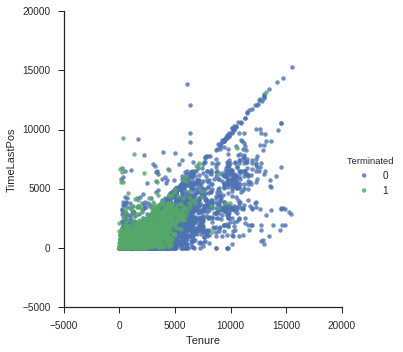

In [122]:
#Let's see the distribution of Terminated vis a vis Tenure and TimeLastPos
sns.lmplot('Tenure', 'TimeLastPos', data=attrition_df, hue='Terminated', fit_reg=False)
plt.show()

There is a huge concentration of Terminated = 1 around the region where both Tenure and TimeLastPos are low.It also seems that there are records where Tenure < TimeLastPos.Also there are records where TimeLastPos = 0 & also Hasbeenpromoted = 'Yes',which is clearly erroneous.So let us inspect these records.

In [123]:
attrition_err = attrition_df.loc[(attrition_df['TimeLastPos'] > attrition_df['Tenure']) | (attrition_df['TimeLastPos'] == 0)]
attrition_err.head()
attrition_err.shape

(1278, 14)

There are 1278 records which contain Tenure values which are less than TimeLastPos and where TimeLastPos = 0.For the records where TimeLastPos = 0 it can be assumed that they have been promoted recently and it is not updated in the system.But what about the records where Tenure < TimeLastPos.It is clearly an error and in absence of interaction with the database maintainer/business,inclination is to either remove such records or remove the variable TimeLastPos.But let's see the distribution of Terminated in these set of records.

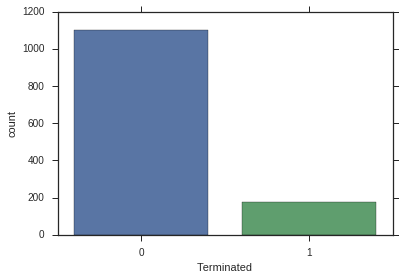

In [124]:
# Employees Left-Stayed Ratio
employees_left_plt = sns.countplot(x = "Terminated",data = attrition_err)

The proportion of Terminated = 0 is certainly much more than in the sample which includes this data also.Can it be that there is a reason for these anomalies to exist.Do they point towards something- might be an error during the data capturing process for these employees.
Now let us find out if the variable TimeLastPos is an important predictor.

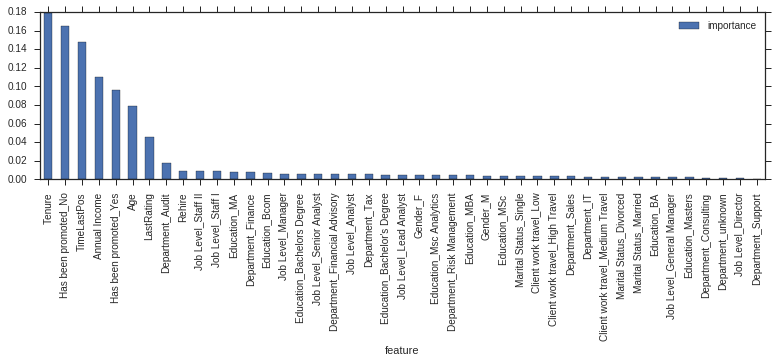

In [125]:
# load X and y
attrition_ohe = pd.get_dummies(attrition_df.drop('Terminated',axis = 1))
predictors = attrition_ohe.columns
X = attrition_ohe[predictors]
y = attrition_df['Terminated']
y = y.ravel()

# Build a forest and compute the feature importances
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

clf = RandomForestClassifier(max_features=5)
clf.fit(X_train.values, y_train)

#show to plot importances
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize = (13,3))

TimeLastPos is the third most important variable.RandomForests have difficulty in selecting important variables when they are highly correlated.Let's see the correlation plot between Tenure and TimeLastPos.

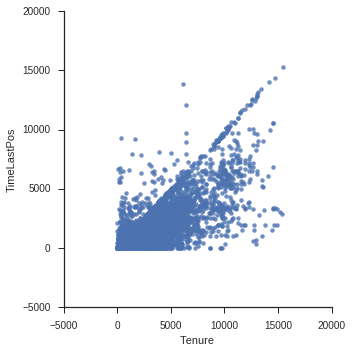

In [126]:
sns.lmplot('Tenure', 'TimeLastPos', data=attrition_df, fit_reg=False)
plt.show()

There is high correlation between the variables as is evident from this figure.Hence we will remove TimeLastPos from the data for modelling purposes.Also,more than number of days since last promotion, a variable like NumberofTimes promoted during Tenure will be more helpful.

Visualization

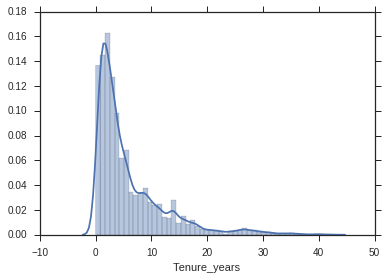

In [128]:
attrition_df['Tenure_years']= round(round((attrition_df['Tenure']/365)*12)/12,1)
attrition_df.drop('Tenure', axis=1, inplace=True)
x = attrition_df['Tenure_years']
sns.distplot(x)

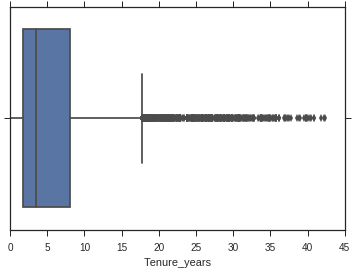

In [129]:
# It seems there are outliers ,so let's verify with a box-plot
sns.boxplot(x)

There are large number of people who have been working in the company for more than 20 years.We will create Tenure Buckets and see the characteristics of this group.

In [130]:
bins = [0, 3, 5, 10, 15, 20, 43]
group_names = ['0-3', '3-5', '5-10', '10-15','15-20','+20']
tenure_year_bucket = pd.cut(attrition_df['Tenure_years'], bins, labels=group_names)
attrition_df['tenure_year_bucket'] = pd.cut(attrition_df['Tenure_years'], bins, labels=group_names)
attrition_df.tenure_year_bucket.fillna('0-3',inplace = True)
sum(attrition_df.tenure_year_bucket.isnull())

0

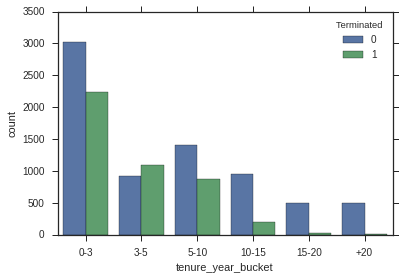

In [131]:
# See the distribution of Terminated across all age buckets
ax = sns.countplot(x="tenure_year_bucket", hue="Terminated", data=attrition_df)

This clearly shows that there are large number of people in the Tenure Bucket of 0-3 and 3-5 years who have left.
What might be the reason? Let's see the number of promotions in these buckets.

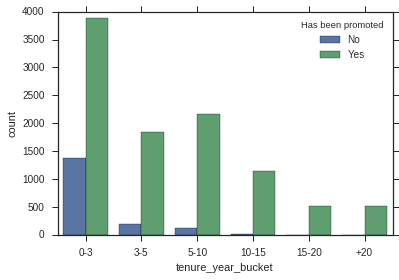

In [132]:
ax = sns.countplot(x="tenure_year_bucket", hue="Has been promoted", data=attrition_df)

There seems to be no evidence suggesting that promotions is a problem,can it be that people are leaving due to Travel issues or Departmental problems.

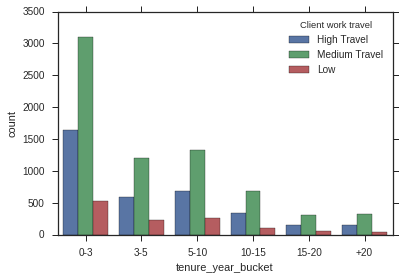

In [133]:
ax = sns.countplot(x="tenure_year_bucket", hue="Client work travel", data=attrition_df)

In the tenure bracket of 0-3 there seems to be quite a lot of travel both but this does not offer any conclusive 
evidence.Is it a problem in the departments?

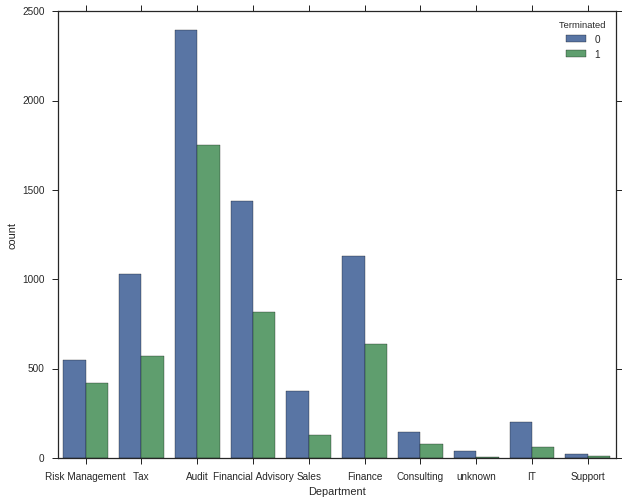

In [134]:
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x="Department", hue="Terminated", data=attrition_df)

Audit and Financial Advisory seems to have a large number of people leaving.Let's drill down.

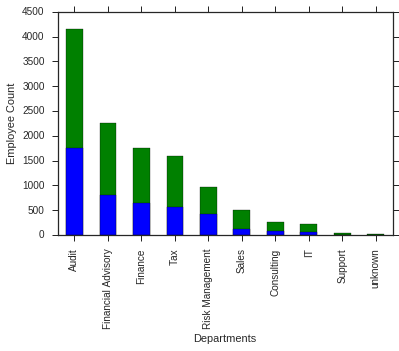

Percentage of employees that left by department 

 Risk Management       43.52
Audit                 42.25
Financial Advisory    36.18
Finance               36.09
Tax                   35.65
Consulting            35.45
Support               29.63
Sales                 24.95
IT                    23.95
unknown                7.32
Name: Department, dtype: float64


In [135]:
left_data = attrition_df[attrition_df.Terminated == 1]
attrition_df.Department.value_counts().plot(kind='bar',color = 'green')
left_data.Department.value_counts().plot(kind='bar', color = 'blue')
plt.title =('Share of Employees that Left by Department')
plt.xlabel('Departments')
plt.ylabel('Employee Count')
plt.show()
percent_left = round(left_data.Department.value_counts()/ attrition_df.Department.value_counts() * 100, 2)
print('Percentage of employees that left by department \n\n', percent_left.sort_values(ascending = False))

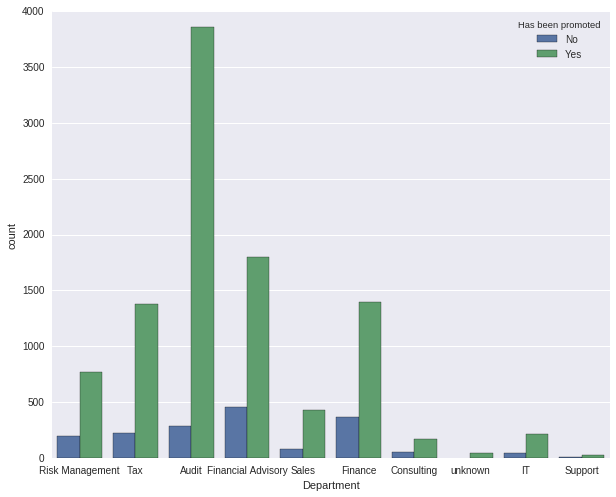

In [61]:
# Let's see the promotions by Dept.
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x="Department", hue="Has been promoted", data=attrition_df)

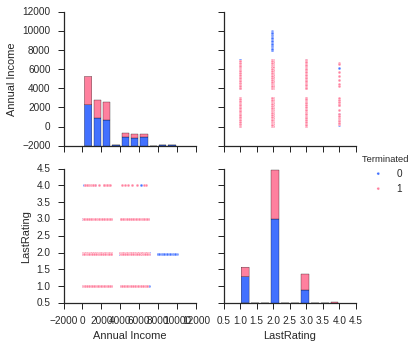

In [75]:
#let's pairplot
plt.figure(figsize=[10,8])
#sns.set(style="ticks")
sns.pairplot(attrition_df, hue='Terminated',palette={0:(0.2588,0.4433,1.0),1:(1.0,0.5,0.62)},
             vars=['Annual Income','LastRating'],plot_kws={"s": 8})
plt.show()

It seems that the Annual Income is a cause for many people leaving.Let us divide the Income into buckets - 'Low',
'Medium' and 'High' and try to re-confirm.

count    11780.000000
mean      2249.867827
std       1938.430798
min        100.000000
25%        790.000000
50%       1715.000000
75%       2790.000000
max       9952.000000
Name: Annual Income, dtype: float64

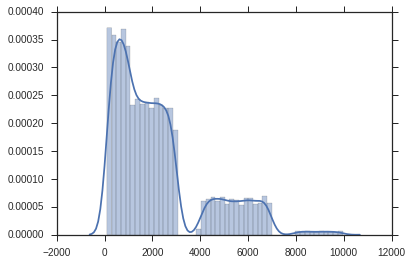

In [86]:
sns.distplot(np.array(attrition_df['Annual Income'].values));attrition_df['Annual Income'].describe()

In [137]:
#Divide Annual Income similarly
bins = [0, 1715, 3000,10000]
group_names = ['Low', 'Medium', 'High']
salary_bucket = pd.cut(attrition_df['Annual Income'], bins, labels=group_names)
attrition_df['salary_bucket'] = pd.cut(attrition_df['Annual Income'], bins, labels=group_names)
attrition_df.salary_bucket.value_counts()

Low       5892
Medium    3571
High      2317
Name: salary_bucket, dtype: int64

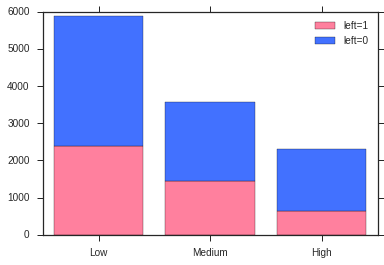

TypeError: 'str' object is not callable

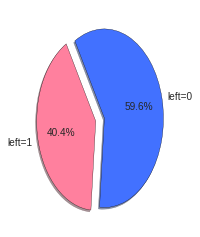

In [142]:
fig = plt.figure()
ax = fig.add_subplot(111)
salary_tick = ['Low','Medium','High']
#number of the the people in each group for both the ones who left and the ones who did not
salary_left = attrition_df[attrition_df['Terminated'] == 1].salary_bucket.value_counts()[0:3]
salary_not_left = attrition_df[attrition_df['Terminated'] == 0].salary_bucket.value_counts()[0:3]

ax.bar(np.arange(len(salary_tick)),salary_left,align='center',color=(1.0,0.5,0.62))
ax.bar(np.arange(len(salary_tick)),salary_not_left,align='center',color=(0.2588,0.4433,1.0),bottom=salary_left)

plt.legend(['left=1','left=0'])
plt.xticks(np.arange(len(salary_tick)), salary_tick)
plt.show()

plt.figure(figsize=[9,4])

for i in range(0,3):
    plt.subplot(1,3,i+1)
    plt.pie([salary_left[i],salary_not_left[i]],
           labels=['left=1','left=0'],
           shadow=True,startangle=120,colors=[(1.0,0.5,0.62),(0.2588,0.4433,1.0)],
           autopct='%1.1f%%',explode=[0.15,0])
    plt.title(salary_tick[i])
plt.show()